In [109]:
import pandas as pd
from collections import OrderedDict,Counter
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc,make_scorer,roc_auc_score,f1_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.preprocessing import StandardScaler,label_binarize,PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import Trials
from hyperopt import tpe
from hyperopt import fmin
import seaborn as sns
import lightgbm as gbm
from imblearn.combine import SMOTETomek
import helper_functions
print('loaded helper_functions.py')
import objective_functions
print('loaded objective_functions which contains objective functions of the ML models we are optimizing using bayesian optimization')

loaded helper_functions.py
loaded objective_functions which contains objective functions of the ML models we are optimizing using bayesian optimization


In [2]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 150

In [3]:
train = pd.read_csv('training_set.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,tamviv,escolari,cielorazo,dis,female,parentesco1,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,age,Target,dependency,instlevel0,rent-missing,wall_attrib,floor_attrib,roof_attrib,water_attrib,electric_attrib,sanitary_attrib,energy_attrib,wall_qual,roof_qual,floor_qual,edu_level,ownership_status,area,person/room,prop_male,prop_female,rent/person,rent/room,without_spouse,female_head,prop_under_12,prop_adults,prop_elderly,mean_edu_child,mean_edu_teen,standard_of_living,house_quality,safe_waste_disposal,gadgets,n_gadgets,gadget/person,age-min,age-max,age-sum,age-mean,age-std,age-range_,escolari-min,escolari-max,escolari-sum,escolari-mean,escolari-std,escolari-range_,v2a1-min,v2a1-sum,v2a1-std,v2a1-range_,house_quality-min,house_quality-sum,house_quality-std,house_quality-range_,standard_of_living-min,standard_of_living-sum,standard_of_living-std,standard_of_living-range_,dependency-min,dependency-sum,dependency-std,dependency-range_,gadgets-min,gadgets-sum,gadgets-std,gadgets-range_,gadget/person-min,gadget/person-sum,gadget/person-std,gadget/person-range_,n_gadgets-sum,n_gadgets-std,n_gadgets-range_
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,10,1,0,0,1,21eb7fcc1,0,1,0,1,10.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,43,4,0.0,0,0,6,5,4,2,3,3,2,1,0,0,3,2,1,3.00,1.0,0.0,190000.0,63333.333333,1,0,0.00,1.0,0.0,0.0,0.0,0.713333,0.375000,1,0.4,1.0,1.0,43,43,43,43.0,0.000000,0,10,10,10,10.00,0.000000,0,190000.0,190000.0,0.0,0.0,0.375000,0.375000,0.0,0.0,0.713333,0.713333,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,12,1,0,0,1,0e5d7a658,0,1,1,1,12.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,67,4,0.0,0,0,3,3,3,2,3,3,3,1,1,1,7,2,1,4.00,1.0,0.0,135000.0,33750.000000,1,0,0.00,1.0,1.0,0.0,0.0,0.820000,0.437500,1,0.6,2.0,2.0,67,67,67,67.0,0.000000,0,12,12,12,12.00,0.000000,0,135000.0,135000.0,0.0,0.0,0.437500,0.437500,0.0,0.0,0.820000,0.820000,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,11,1,1,1,1,2c7317ea8,0,1,1,1,11.0,2,0.500000,0,0,0,0,1,0,0,0,0,0,92,4,0.0,0,0,3,5,3,2,3,3,3,1,2,2,4,4,1,8.00,0.0,1.0,0.0,0.000000,1,1,0.00,1.0,1.0,0.0,0.0,0.740000,0.645833,1,0.2,0.0,0.0,92,92,92,92.0,0.000000,0,11,11,11,11.00,0.000000,0,0.0,0.0,0.0,0.0,0.645833,0.645833,0.0,0.0,0.740000,0.740000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,9,1,0,0,0,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,17,4,1.0,0,0,6,5,3,2,3,3,3,2,2,2,3,2,1,1.25,0.5,0.5,45000.0,36000.000000,1,0,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1,0.6,4.0,1.0,8,38,100,25.0,14.899664,30,2,11,33,8.25,4.272002,9,180000.0,720000.0,0.0,0.0,0.833333,3.333333,0.0,0.0,0.820000,3.280000,0.0,0.0,1.0,4.0,0.0,0.0,0.6,2.4,0.0,0.0,1.0,4.0,0.0,0.0,16.0,0.0,0.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,11,1,0,1,0,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,37,4,1.0,0,0,6,5,3,2,3,3,3,2,2,2,4,2,1,1.25,0.5,0.5,45000.0,36000.000000,0,0,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1,0.6,4.0,1.0,8,38,100,25.0,14.899664,30,2,11,33,8.25,4.272002,9,180000.0,720000.0,0.0,0.0,0.833333,3.333333,0.0,0.0,0.820000,3.280000,0.0,0.0,1.0,4.0,0.0,0.0,0.6,2.4,0.0,0.0,1.0,4.0,0.0,0.0,16.0,0.0,0.0


In [4]:
test = pd.read_csv('testing_set.csv')
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,tamviv,escolari,cielorazo,dis,female,parentesco1,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,age,dependency,instlevel0,rent-missing,wall_attrib,floor_attrib,roof_attrib,water_attrib,electric_attrib,sanitary_attrib,energy_attrib,wall_qual,roof_qual,floor_qual,edu_level,ownership_status,area,person/room,prop_male,prop_female,rent/person,rent/room,without_spouse,female_head,prop_under_12,prop_adults,prop_elderly,mean_edu_child,mean_edu_teen,standard_of_living,house_quality,gadgets,n_gadgets,gadget/person,age-min,age-max,age-sum,age-mean,age-std,age-range_,escolari-min,escolari-max,escolari-sum,escolari-mean,escolari-std,escolari-range_,v2a1-min,v2a1-sum,v2a1-std,v2a1-range_,house_quality-min,house_quality-sum,house_quality-std,house_quality-range_,standard_of_living-min,standard_of_living-sum,standard_of_living-std,standard_of_living-range_,dependency-min,dependency-sum,dependency-std,dependency-range_,gadgets-min,gadgets-sum,gadgets-std,gadgets-range_,gadget/person-min,gadget/person-sum,gadget/person-std,gadget/person-range_,n_gadgets-sum,n_gadgets-std,n_gadgets-range_,safe_waste_disposal
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,0,1,0,0,0,72958b30c,1,2,0,3,16.500000,2,1.5,1,0,1,2,1,0,0,0,0,0,4,0.5,0,0,6,5,3,2,3,3,2,2,2,2,0,4,1,1.666667,0.666667,0.333333,0.0,0.0,0,0,0.333333,0.666667,0.0,0.0,0.0,0.753333,0.833333,0.6,2.0,0.666667,4,41,86,28.666667,21.36196,37,0,17,33,11.0,9.539392,17,0.0,0.0,0.0,0.0,0.833333,2.500000,0.0,0.0,0.753333,2.26,0.0,0.0,0.5,1.5,0.0,0.0,0.6,1.8,0.0,0.0,0.666667,2.0,0.0,0.0,6.0,0.0,0.0,1
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,16,1,0,0,0,72958b30c,1,2,0,3,16.500000,2,1.5,1,0,1,2,1,0,0,0,0,0,41,0.5,0,0,6,5,3,2,3,3,2,2,2,2,7,4,1,1.666667,0.666667,0.333333,0.0,0.0,0,0,0.333333,0.666667,0.0,0.0,0.0,0.753333,0.833333,0.6,2.0,0.666667,4,41,86,28.666667,21.36196,37,0,17,33,11.0,9.539392,17,0.0,0.0,0.0,0.0,0.833333,2.500000,0.0,0.0,0.753333,2.26,0.0,0.0,0.5,1.5,0.0,0.0,0.6,1.8,0.0,0.0,0.666667,2.0,0.0,0.0,6.0,0.0,0.0,1
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,17,1,0,1,1,72958b30c,1,2,0,3,16.500000,2,1.5,1,0,1,2,1,0,0,0,0,0,41,0.5,0,0,6,5,3,2,3,3,2,2,2,2,8,4,1,1.666667,0.666667,0.333333,0.0,0.0,0,1,0.333333,0.666667,0.0,0.0,0.0,0.753333,0.833333,0.6,2.0,0.666667,4,41,86,28.666667,21.36196,37,0,17,33,11.0,9.539392,17,0.0,0.0,0.0,0.0,0.833333,2.500000,0.0,0.0,0.753333,2.26,0.0,0.0,0.5,1.5,0.0,0.0,0.6,1.8,0.0,0.0,0.666667,2.0,0.0,0.0,6.0,0.0,0.0,1
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,16,1,0,0,1,5b598fbc9,0,1,0,1,16.000000,1,1.0,1,0,1,2,1,0,0,0,0,0,59,0.0,0,0,6,5,3,2,3,3,3,2,2,2,7,4,1,14.000000,1.000000,0.000000,0.0,0.0,1,0,0.000000,1.000000,0.0,0.0,0.0,0.860000,0.833333,0.8,3.0,3.000000,59,59,59,59.000000,0.00000,0,16,16,16,16.0,0.000000,0,0.0,0.0,0.0,0.0,0.833333,0.833333,0.0,0.0,0.860000,0.86,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.0,0.0,3.000000,3.0,0.0,0.0,3.0,0.0,0.0,1
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,11,1,0,1,1,1e2fc704e,1,0,0,1,9.157474,2,0.5,0,0,1,1,1,0,0,0,0,0,18,0.0,0,0,6,5,3,2,3,3,3,1,2,2,4,2,1,4.000000,0.000000,1.000000,175000.0,43750.0,1,1,0.000000,0.000000,0.0,0.0,11.0,0.820000,0.708333,0.6,2.0,2.000000,18,18,18,18.000000,0.00000,0,11,11,11,11.0,0.000000,0,175000.0,175000.0,0.0,0.0,0.708333,0.708333,0.0,0.0,0.820000,0.82,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0,2.000000,2.0,0.0,0.0,2.0,0.0,0.0,1


In [5]:
#we would only be using heads of the household for training
train_head = train[train.parentesco1 == 1].reset_index(drop=True)

In [6]:
train_head.shape

(2973, 116)

In [7]:
submission_base = test[['Id', 'idhogar']].copy()
test_ids = test['idhogar']

In [8]:
train_head.drop(['Id','idhogar'],axis=1,inplace=True)
test.drop(['Id','idhogar'],axis=1,inplace=True)

In [9]:
train_head.shape

(2973, 114)

In [10]:
test.shape

(23856, 113)

In [11]:
feat_cols = train_head.columns.difference(['Target'])
train_feat = train_head[feat_cols].values

In [12]:
#We would be scaling our data as a preprocessing step using Standard Scaler

In [13]:
scaler = PowerTransformer()
train_scaled = scaler.fit_transform(train_feat)

In [14]:
test_scaled = scaler.transform(test)

In [15]:
features = train_scaled
labels = train_head['Target']

### lets try to visualize our data using TSNE and investigate if the classes look seperable

tsne with perplexity 5 completed in 0.6173712452252705 min
tsne with perplexity 30 completed in 0.8114856402079265 min
tsne with perplexity 50 completed in 0.9571984648704529 min
tsne with perplexity 100 completed in 1.185636079311371 min


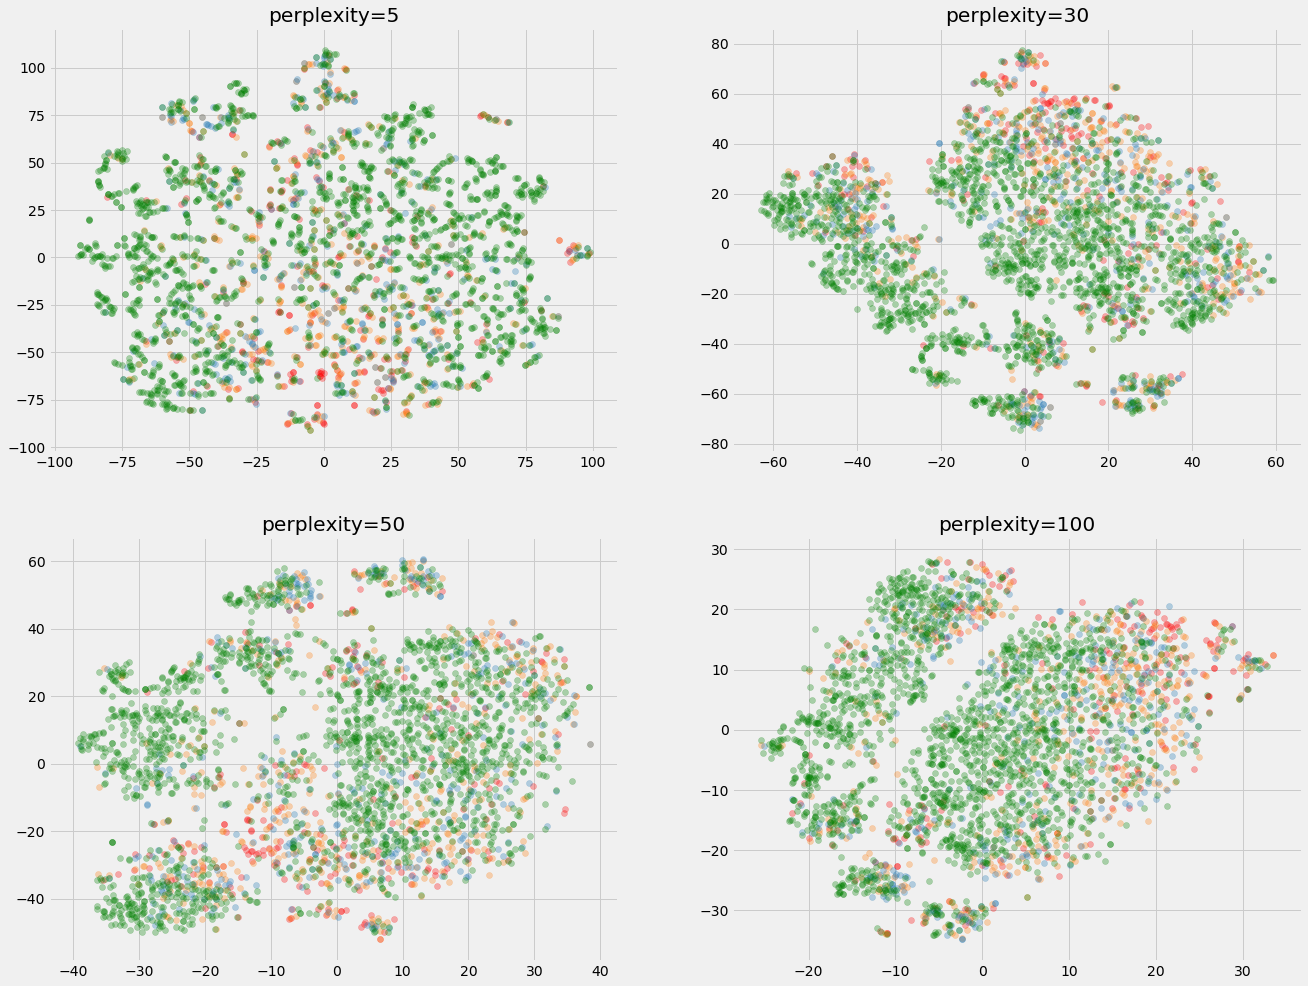

In [18]:
perplexities = [5,30,50,100]
targets = [1,2,3,4]
labels_ = ['extreme','moderate','vulnerable','non-vulnerable']
colors = ['r','tab:orange','tab:blue','g']
plt.figure(figsize = (20, 16))
for i,perplexity in enumerate(perplexities):
    ax = plt.subplot(2,2,i+1)
    t0 = time()
    tsne_embedding = TSNE(n_components=2,perplexity=perplexity)
    embedding = tsne_embedding.fit_transform(features)
    t1 = time()
    print('tsne with perplexity {} completed in {} min'.format(perplexity,(t1-t0)/60))
    tsne_result = pd.DataFrame({'X':embedding[:,0],'Y':embedding[:,1],'target':labels})
    for target,label,color in [(targets[i],labels_[i],colors[i]) for i in range(0,4)]:
        ax.scatter(x=tsne_result['X'][tsne_result.target == target].values,y=tsne_result['Y'][tsne_result.target == target].values,color= color,label=\
        label,alpha=0.3)
    plt.title('perplexity={}'.format(perplexity))


### helper functions

In [32]:
f1_scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

def build_gauss_kernel(X1,X2,gamma):
    pairwise_dists = cdist(X1, X2, 'sqeuclidean')
    K = exp(-pairwise_dists ** 2 / gamma ** 2)
    return K

def compare_distributions(results,param):
    uniform_C = list()
    for i in range(0,200):
        x = sample(space)
        uniform_C.append(x[param])

    sns.kdeplot(uniform_C, label = 'prior')
    sns.kdeplot(results[param], label = 'Bayes Optimization')
    plt.legend(loc = 'best')
    plt.title('{} Distribution'.format(param))
    plt.xlabel('{}'.format(param)); plt.ylabel('Density');
    plt.show();
    
#helper functions
def plot_feature_importances(df, n = 20, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

In [17]:
# we would be storing our model results in a dataframe for comparison
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

### lets start with non-parametric methods
### KNN

In [18]:
#cv_model(train, train_labels, model, name, scorer, model_results=None)
for n in [5,10,15,20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = helper_functions.cv_model(features, labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', f1_scorer, model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.33273 with std: 0.02993

KNN with 10 neighbors

10 Fold CV Score: 0.30983 with std: 0.03511

KNN with 15 neighbors

10 Fold CV Score: 0.30539 with std: 0.04978

KNN with 20 neighbors

10 Fold CV Score: 0.29386 with std: 0.04721


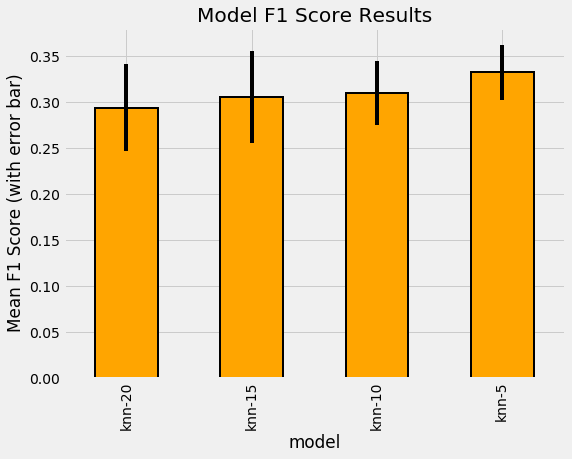

In [19]:
helper_functions.plot_model_results(model_results)

#### It looks like KNN with 5 neighbors gave the highest f1_score.

## SVM

#### support vector machines require optimization of two hyper-parameters,the kernel and the penalty.
#### Therefore,we would be performing hyperparameter tuning using bayesian optimization to tune our SVM model and extract the best possible score

### let me introduce you to bayesian optimization using hyperopt.
### it has 4 components:
#### 1)search space / parameter space which contains probability distributions of a model's hyperparameters
#### 2)objective function which would be minimized by optimization
#### 3)a search algorithm to search the parameter space
#### 4)a Trials object which would store the search results for analysis.

### Note: apart from the kernels to be used with SVM,i would also be using gaussian kernel

In [20]:
#search space
num_features = features.shape[1]
gamma_max = 1/(num_features * features.std())
space = {'C':hp.uniform('C',0.0001,1000),
         'gamma':hp.uniform('gamma',0,gamma_max),
         'kernel':hp.choice('kernel',['rbf','poly','sigmoid','gaussian'])}

In [21]:
from helper_functions import build_gauss_kernel
NUM_FOLDS=5
def SVC_objective(params,num_folds=NUM_FOLDS):
    y_bin = label_binarize(labels, classes=[1,2,3,4])
    n_classes = y_bin.shape[1]
    global ITERATION
    ITERATION += 1
    
    gamma = params['gamma']
    reg = float(params['C'])
    kernel = params['kernel']
    
    if kernel == 'gaussian':
        gaussian_kernel = partial(build_gauss_kernel,gamma=gamma)
        svc = SVC(C=reg,kernel=gaussian_kernel,class_weight='balanced',decision_function_shape='ovr',probability=True)
    else :
        svc = SVC(C=reg,kernel=kernel,gamma=gamma,class_weight='balanced',decision_function_shape='ovr',probability=True)
    
    start = timer()

    scores = cross_val_score(svc,features,labels,cv=5,scoring=f1_scorer)
    
    f1_score_ = np.mean(scores)
    f1_score_std = np.std(scores)
    
    runtime = timer() - start
    
    loss = 1 - f1_score_
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {np.round(f1_score_, 4)}.')

    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': runtime, 'score':f1_score_,'score_std':f1_score_std,'status': STATUS_OK}
    

In [22]:
tpe_algorithm = tpe.suggest

In [23]:
svc_bayes_trials = Trials()

In [24]:
# Global variable
global  ITERATION

ITERATION = 0
PROGRESS = 10
MAX_EVALS = 100

In [25]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

start = timer()
best = fmin(fn = SVC_objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = svc_bayes_trials, rstate = np.random.RandomState(50))
runtime = timer() - start

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.3784.'

'Iteration: 20, Current Score: 0.3168.'

'Iteration: 30, Current Score: 0.3391.'

'Iteration: 40, Current Score: 0.2859.'

'Iteration: 50, Current Score: 0.2884.'

'Iteration: 60, Current Score: 0.2639.'

'Iteration: 70, Current Score: 0.3177.'

'Iteration: 80, Current Score: 0.3163.'

'Iteration: 90, Current Score: 0.2992.'

'Iteration: 100, Current Score: 0.2818.'

In [26]:
print('total runtime for optimization: ',runtime/60,'min')

total runtime for optimization:  57.4728564542949 min


In [27]:
svc_results = helper_functions.dict_to_pd('SVC',svc_bayes_trials.results)

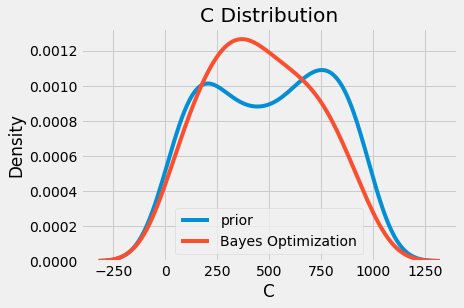

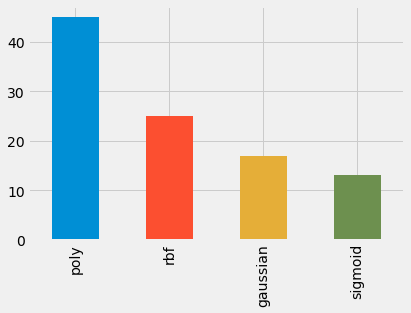

In [34]:
# let us analyse the hyperparameters selected through optimization
compare_distributions(svc_results,'C')
svc_results['kernel'].value_counts().plot.bar()

In [36]:
#selecting the best parameter values
params = dict(svc_results.loc[0,['C','kernel']])
model_results = helper_functions.cv_model(features,labels,SVC(**params,class_weight='balanced',decision_function_shape='ovr',probability=True),'SVC',f1_scorer,model_results)

10 Fold CV Score: 0.32395 with std: 0.07877


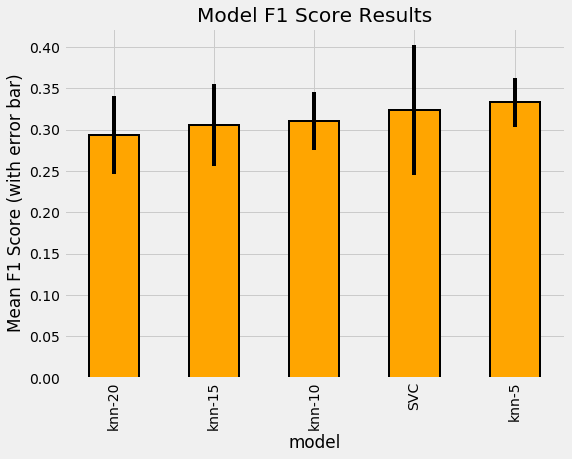

In [40]:
helper_functions.plot_model_results(model_results)

#### SVC has performed marginally better than 5-KNN but both the models show higher std/variability in scores.

In [41]:
space = {'C':hp.uniform('C', 0.001, 1000),
         'penalty':hp.choice('penalty',[{'penalty':'l1','solver':'saga'},
                                        {'penalty':'l2','solver':'sag'}])}

In [49]:
from helper_functions import macro_f1_score,avg_f1
N_FOLDS = 5
def LR_objective(params,num_folds = N_FOLDS):
    
    global ITERATION
    
    ITERATION += 1
    
    penalty = params['penalty']['penalty']
    solver = params['penalty']['solver']
    reg = float(params['C'])
    
    start = timer()
    
    lg_cv = LogisticRegressionCV(Cs=[reg],multi_class='ovr',class_weight='balanced',cv=num_folds,penalty=penalty,solver=solver,scoring=f1_scorer,max_iter=1000)
    lg_cv.fit(features,labels)
    
    runtime = timer() - start
    
    f1_score_,f1_score_std = avg_f1(lg_cv.scores_)
    
    loss = 1 - f1_score_
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {np.round(f1_score_, 4)}.')
    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,'score':f1_score_,'score_std':f1_score_std,
            'train_time': runtime, 'status': STATUS_OK}
    
    
    

In [50]:
tpe_algorithm = tpe.suggest

In [51]:
lr_bayes_trials = Trials()

In [52]:
ITERATION = 0
PROGRESS = 10
MAX_EVALS = 50

In [53]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Global variable
global  ITERATION

start = timer()
best = fmin(fn = LR_objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = lr_bayes_trials, rstate = np.random.RandomState(50))
runtime = timer() - start

'Running Optimization for 50 Trials.'

'Iteration: 10, Current Score: 0.5217.'

'Iteration: 20, Current Score: 0.5222.'

'Iteration: 30, Current Score: 0.5246.'

'Iteration: 40, Current Score: 0.5218.'

'Iteration: 50, Current Score: 0.5222.'

In [54]:
print('total runtime for optimization: ',runtime/60,'min')

total runtime for optimization:  139.25979899005623 min


In [55]:
lr_results = helper_functions.dict_to_pd('LR',lr_bayes_trials.results)

In [56]:
lr_results.head()

,C,iteration,loss,penalty,score,score_std,solver
0,2.429694,27,0.474255,"{'penalty': 'l2', 'solver': 'sag'}",0.525745,0.014028,sag
1,2.735415,30,0.475388,"{'penalty': 'l2', 'solver': 'sag'}",0.524612,0.014782,sag
2,4.217891,26,0.476068,"{'penalty': 'l2', 'solver': 'sag'}",0.523932,0.016570,sag
3,15.741017,2,0.477626,"{'penalty': 'l2', 'solver': 'sag'}",0.522374,0.019419,sag
4,493.645592,5,0.477830,"{'penalty': 'l2', 'solver': 'sag'}",0.522170,0.020369,sag


In [57]:
params = dict(lr_results.loc[0,['C','penalty','solver']])
params

{'C': 2.4296943235862756,
 'penalty': {'penalty': 'l2', 'solver': 'sag'},
 'solver': 'sag'}

In [58]:
#def cv_model(train, train_labels, model, name, scorer, model_results=None):
params = dict(lr_results.loc[0,['C','penalty','solver']])
best_params = {'C':params['C'],'penalty':params['penalty']['penalty'],'solver':params['solver']}
model = LogisticRegression(**best_params,class_weight='balanced',max_iter=1000,multi_class='ovr',verbose=200,n_jobs=4)
model_results = helper_functions.cv_model(features,labels,model,'LR_OPT',f1_scorer,model_results)

10 Fold CV Score: 0.31729 with std: 0.09926


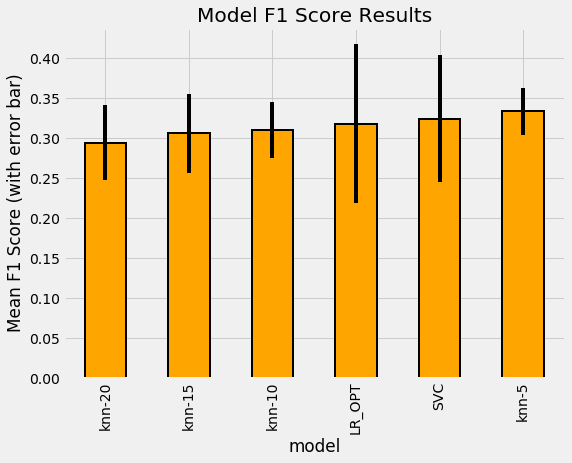

In [59]:
helper_functions.plot_model_results(model_results)

# Ensemble Models

#### we would start with Random Forest Classifier and then proceed to gradient boosting trees
#### Random Forest Classifier would serve as a benchmark for our ensemble models
#### we would also assess the feature importances and reduce our feature space for a better score.

# Random Forest Classifier

In [118]:
# we would first run Random Forest without any optimization

In [62]:
model_results = helper_functions.cv_model(features,labels,RandomForestClassifier(n_estimators=100),'RF',f1_scorer,model_results)

10 Fold CV Score: 0.35296 with std: 0.03762


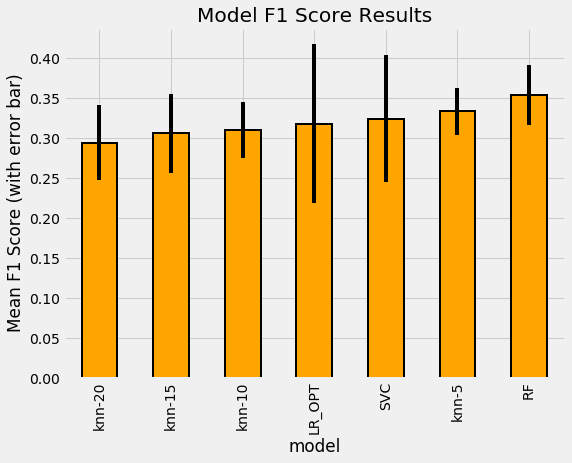

In [63]:
helper_functions.plot_model_results(model_results)

In [120]:
# let us optmize this tree and check if we can improve the score

In [64]:
n_features = features.shape[1]
space = {'max_depth':hp.quniform('max_depth',1,32,1),
         'min_samples_split':hp.uniform('min_samples_split',0.1,1.0),
         'min_samples_leaf':hp.uniform('min_samples_leaf',0.1,0.5),
         'max_features':hp.quniform('max_features',1,n_features,1)
        }

In [66]:
N_FOLDS=5
def RF_objective(params,n_folds=N_FOLDS):
    
    global ITERATION
    ITERATION += 1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_features','max_depth']:
        params[parameter_name] = int(params[parameter_name]) 
    
    start = timer()
    
    rf = RandomForestClassifier(**params,n_estimators=100,class_weight='balanced',n_jobs=4)

    scores = cross_val_score(rf,features,labels,cv=n_folds,scoring=f1_scorer)
    
    f1_score_ = np.mean(scores)
    f1_score_std = np.std(scores)
    
    runtime = timer() - start
    
    loss = 1 - f1_score_
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {np.round(f1_score_, 4)}.')

    
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': runtime, 'score':f1_score_,'score_std':f1_score_std,'status': STATUS_OK}

In [67]:
tpe_algorithm = tpe.suggest

In [68]:
rf_bayes_trials = Trials()

In [69]:
ITERATION = 0
MAX_EVALS = 100
PROGRESS = 10

In [70]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Global variable
global  ITERATION

# Run optimization
best = fmin(fn = RF_objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = rf_bayes_trials, rstate = np.random.RandomState(50))

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.116.'

'Iteration: 20, Current Score: 0.1101.'

'Iteration: 30, Current Score: 0.1137.'

'Iteration: 40, Current Score: 0.3266.'

'Iteration: 50, Current Score: 0.0527.'

'Iteration: 60, Current Score: 0.0505.'

'Iteration: 70, Current Score: 0.3686.'

'Iteration: 80, Current Score: 0.3739.'

'Iteration: 90, Current Score: 0.2851.'

'Iteration: 100, Current Score: 0.3076.'

In [72]:
rf_results = helper_functions.dict_to_pd('RF',rf_bayes_trials.results)

In [76]:
rf_results.head()

,iteration,loss,max_depth,max_features,min_samples_leaf,min_samples_split,score,score_std
0,80,0.626117,22,79,0.112866,0.209376,0.373883,0.049069
1,56,0.627591,21,90,0.101929,0.325408,0.372409,0.037320
2,68,0.628395,28,109,0.115355,0.291288,0.371605,0.035355
3,36,0.629243,29,62,0.101863,0.119406,0.370757,0.037097
4,85,0.630638,18,96,0.110667,0.259500,0.369362,0.043395


In [74]:
param_list = ['max_depth','max_features','min_samples_split','min_samples_leaf']
best_params = dict(rf_results.loc[0,param_list])
for parameter_name in ['max_features','max_depth']:
    best_params[parameter_name] = int(best_params[parameter_name]) 

In [77]:
#lets try these hyper-parameter values assess the validation score
model = RandomForestClassifier(**best_params,class_weight='balanced',n_jobs=4,n_estimators=100)
model_results = helper_functions.cv_model(features,labels,model,'RF_OPT',f1_scorer,model_results)

10 Fold CV Score: 0.37115 with std: 0.05015


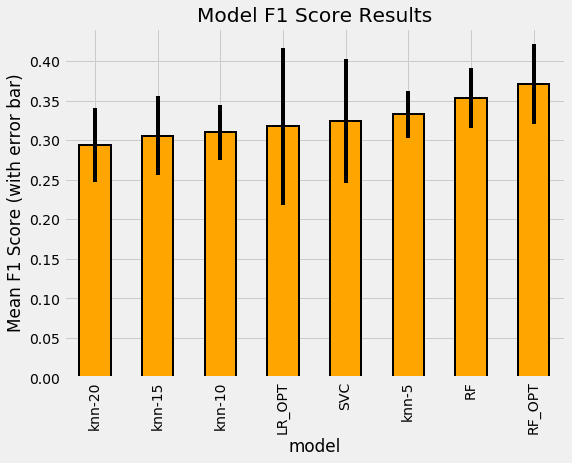

In [78]:
helper_functions.plot_model_results(model_results)

In [79]:
#let us investigate the feature importances given by our random forest classifier
model = RandomForestClassifier(**best_params,class_weight='balanced',n_jobs=4,n_estimators=100)
model.fit(features,labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=22, max_features=79,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.1128660838972059,
            min_samples_split=0.20937602842954106,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
feat_imp = pd.DataFrame({'feature':feat_cols,'importance':model.feature_importances_})

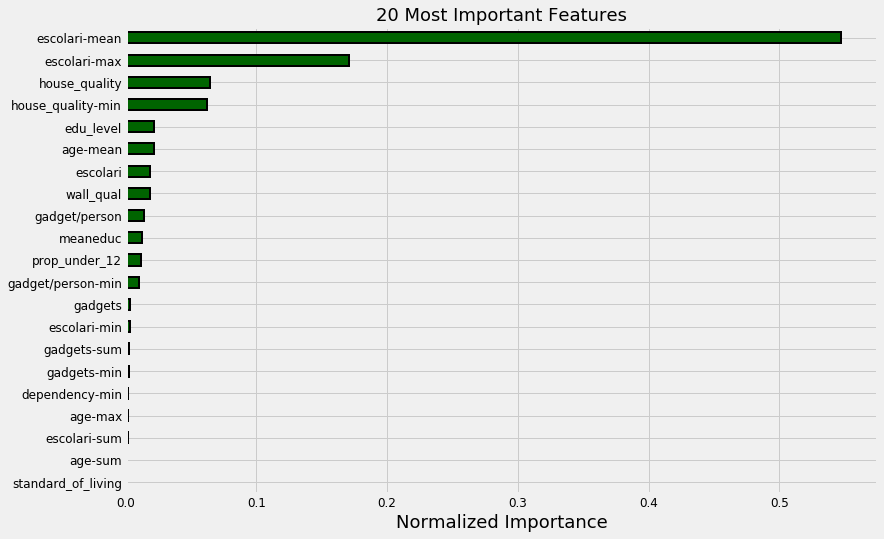

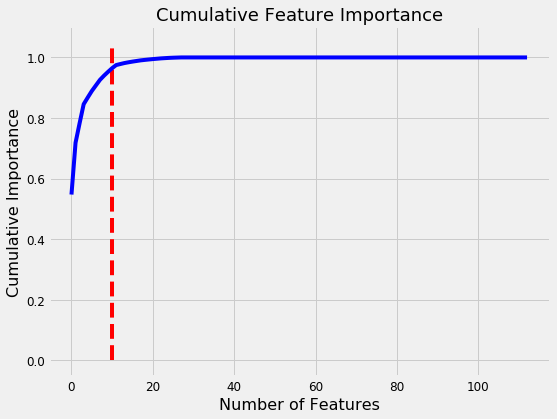

10 features required for 95% of cumulative importance.


In [81]:
res = helper_functions.plot_feature_importances(feat_imp,n=20,threshold=0.95)

#### we can observe that most of the engineered features are in the top 20 most important features

# Light GBM

In [205]:
# let us run light GBM without optimization to set a baseline score and then tune the model with bayesian optimization.

In [82]:
n_folds=5
strkfold = StratifiedKFold(n_splits = n_folds, shuffle = True)

clf = gbm.LGBMClassifier(n_estimators=1000,objective='multiclass',importance_type='split',n_jobs=-1,metric=None)
    
valid_scores = []
best_estimators = []
run_times = []
    
    # Perform n_folds cross validation
for train_indices, valid_indices in strkfold.split(features, labels):
        
        # Training and validation data
    X_train = features[train_indices]
    X_valid = features[valid_indices]
    y_train = labels[train_indices]
    y_valid = labels[valid_indices]
        
    
    start = timer()
        
    clf.fit(X_train, y_train, early_stopping_rounds = 400, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        
    end = timer()
        # Record the validation fold score
    valid_scores.append(clf.best_score_['valid']['macro_f1'])
    best_estimators.append(clf.best_iteration_)
        
    run_times.append(end - start)
    
score = np.mean(valid_scores)
score_std = np.std(valid_scores)
    
estimators = int(np.mean(best_estimators))
    
print('validation score:',score,' with std: ',score_std)
print('no. of estimators:{}'.format(estimators))

Training until validation scores don't improve for 400 rounds.
[400]	train's multi_logloss: 0.00242429	train's macro_f1: 1	valid's multi_logloss: 1.55362	valid's macro_f1: 0.334633
Early stopping, best iteration is:
[24]	train's multi_logloss: 0.563	train's macro_f1: 0.76409	valid's multi_logloss: 0.840312	valid's macro_f1: 0.37992
Training until validation scores don't improve for 400 rounds.
[400]	train's multi_logloss: 0.00246024	train's macro_f1: 1	valid's multi_logloss: 1.5439	valid's macro_f1: 0.337924
Early stopping, best iteration is:
[30]	train's multi_logloss: 0.503558	train's macro_f1: 0.796462	valid's multi_logloss: 0.838105	valid's macro_f1: 0.370341
Training until validation scores don't improve for 400 rounds.
[400]	train's multi_logloss: 0.00250978	train's macro_f1: 1	valid's multi_logloss: 1.51416	valid's macro_f1: 0.359766
Early stopping, best iteration is:
[1]	train's multi_logloss: 1.28671	train's macro_f1: 0.566881	valid's multi_logloss: 1.30545	valid's macro_f1: 0

In [83]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_NO_OPT"], 
                                                   'cv_mean': [np.mean(valid_scores)],
                                                   'cv_std':  [np.std(valid_scores)]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

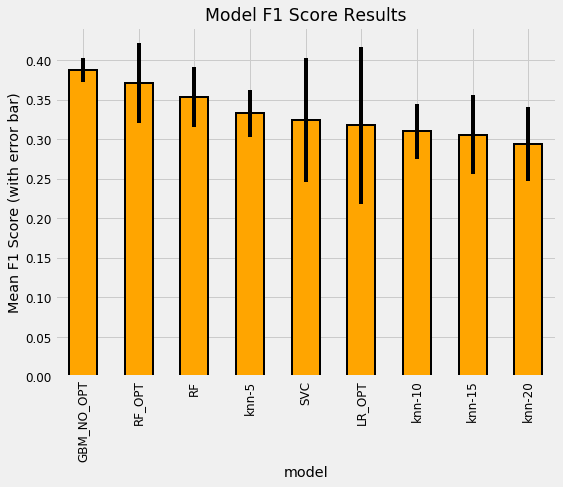

In [84]:
helper_functions.plot_model_results(model_results)

### GBM scores much better without optimization than other previously implemented models,especially random forest with optimization as it comes from the same family of machine learning models.

In [215]:
#lets tune our GBM model and then compare the scores as well

In [85]:
#domain space
space = {
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 19, 45, 1),
    'bagging_fraction':hp.uniform('feature_fraction',0.8,1),
    'min_split_gain':hp.uniform('min_split_gain',0.001,0.1),
    'min_child_weight':hp.quniform('min_child_weight',5,50,1),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 5.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 3.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'max_depth':hp.choice('max_depth',[-1,4,6,8,10,12])
}

In [86]:
N_FOLDS=5
def gbm_objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    #y_bin = label_binarize(Y_resampled, classes=[1,2,3,4])
    #n_classes = y_bin.shape[1]
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples','min_child_weight']:
        params[parameter_name] = int(params[parameter_name])
        
    strkfold = StratifiedKFold(n_splits = n_folds, shuffle = True)
    
    clf = gbm.LGBMClassifier(**params,learning_rate = 0.1,n_estimators=10000,objective='multiclass',importance_type='split',n_jobs=-1,metric=None)
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    # Perform n_folds cross validation
    for train_indices, valid_indices in strkfold.split(features, labels):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
    
        start = timer()
        
        clf.fit(X_train, y_train, early_stopping_rounds = 400, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 100)
        
        end = timer()
        # Record the validation fold score
        valid_scores.append(clf.best_score_['valid']['macro_f1'])
        best_estimators.append(clf.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    params['n_estimators'] = estimators
    
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

    

In [87]:
tpe_algorithm = tpe.suggest

In [88]:
gbm_bayes_trials = Trials()

In [89]:
ITERATION = 200
MAX_EVALS = 300
PROGRESS = 10

In [90]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Global variable
global  ITERATION

# Run optimization
best = fmin(fn = gbm_objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = gbm_bayes_trials, rstate = np.random.RandomState(50))

'Running Optimization for 200 Trials.'

'Iteration: 10, Current Score: 0.3993.'

'Iteration: 20, Current Score: 0.3592.'

'Iteration: 30, Current Score: 0.3995.'

'Iteration: 40, Current Score: 0.3805.'

'Iteration: 50, Current Score: 0.3806.'

'Iteration: 60, Current Score: 0.3653.'

'Iteration: 70, Current Score: 0.3916.'

'Iteration: 80, Current Score: 0.3534.'

'Iteration: 90, Current Score: 0.379.'

'Iteration: 100, Current Score: 0.3616.'

'Iteration: 110, Current Score: 0.3926.'

'Iteration: 120, Current Score: 0.3678.'

'Iteration: 130, Current Score: 0.3839.'

'Iteration: 140, Current Score: 0.3831.'

'Iteration: 150, Current Score: 0.3942.'

'Iteration: 160, Current Score: 0.3908.'

'Iteration: 170, Current Score: 0.3762.'

'Iteration: 180, Current Score: 0.3781.'

'Iteration: 190, Current Score: 0.3931.'

'Iteration: 200, Current Score: 0.3891.'

In [91]:
gbm_results = helper_functions.dict_to_pd('GBM',gbm_bayes_trials.results)

In [92]:
gbm_results.head()

,bagging_fraction,boosting_type,colsample_bytree,loss,max_depth,min_child_samples,min_child_weight,min_split_gain,n_estimators,num_leaves,reg_alpha,reg_lambda,score,score_std,subsample,subsample_for_bin,train_std
0,0.989518,goss,0.935032,0.590758,8,25,5,0.075548,41,22,2.707682,0.172792,0.409242,0.030605,1.000000,300000,0.246190
1,0.966186,gbdt,0.778722,0.597716,8,85,30,0.038231,55,28,2.603666,0.757040,0.402284,0.016082,0.987078,280000,0.117063
2,0.945991,dart,0.908507,0.598204,8,110,9,0.092974,238,33,2.632694,1.160205,0.401796,0.024001,0.502269,180000,0.403419
3,0.964053,dart,0.747993,0.599435,-1,60,10,0.058057,162,31,1.547829,0.440067,0.400565,0.025054,0.999656,220000,2.695399
4,0.956631,dart,0.808661,0.599500,8,20,7,0.090943,149,29,3.484831,0.607948,0.400500,0.025059,0.525075,240000,2.196082


In [93]:
def model_gbm(features, labels, feature_list,nfolds = 5, hyp = None,with_oversampling=False):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feat_names = feature_list

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'bagging_fraction': 0.9410068419634143,
 'boosting_type': 'dart',
 'colsample_bytree': 0.7568976937851579,
 'min_child_samples': 35,
 'min_child_weight': 26.709811008563438,
 'min_split_gain': 0.05365377666160257,
 'num_leaves': 24,
 'reg_alpha': 1.0462496845733886,
 'reg_lambda': 0.6874474257041001,
 'subsample': 0.6621345483522493,
 'subsample_for_bin': 240000}
    
    # Build the model
    model = gbm.LGBMClassifier(**params, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced')
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feat_names))
    
    # Convert to arrays for indexing
    #features = np.array(features)
    #test_features = np.array(test_features)
    #labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        class_dist = Counter(y_train)
        ratio_ = {4:class_dist[4],3:class_dist[3]*2,2:class_dist[2]*2,1:class_dist[1]*2}
        
        if with_oversampling:
            sm = SMOTETomek(random_state=50)
            train_set,train_labels = sm.fit_sample(X_train,y_train)
        else:
            train_set,train_labels = X_train,y_train
        
        
        
        
        # Train with early stopping
        model.fit(train_set, train_labels, early_stopping_rounds = 400, 
                  eval_metric = macro_f1_score,
                  eval_set = [(train_set, train_labels), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        '''# Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)'''
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feat_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    '''if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances'''
    
    '''# Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)'''
    
    # return the submission and feature importances along with validation scores
    return feature_importances, valid_scores
    

In [98]:
param_list = ['bagging_fraction','boosting_type','colsample_bytree','max_depth','min_child_samples','min_child_weight','min_split_gain','n_estimators','num_leaves','reg_alpha','reg_lambda','subsample','subsample_for_bin']
best_params = dict(gbm_results.loc[0,param_list])

In [99]:
gbm_fi,valid_scores = model_gbm(features,labels,feat_cols,hyp=best_params)

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.898007	valid's macro_f1: 0.403858
[400]	train's macro_f1: 0.955523	valid's macro_f1: 0.403703
Early stopping, best iteration is:
[13]	train's macro_f1: 0.613882	valid's macro_f1: 0.435364


'Fold 1, Validation Score: 0.43536, Estimators Trained: 13'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.897456	valid's macro_f1: 0.411524
[400]	train's macro_f1: 0.960837	valid's macro_f1: 0.411172
Early stopping, best iteration is:
[172]	train's macro_f1: 0.886099	valid's macro_f1: 0.422469


'Fold 2, Validation Score: 0.42247, Estimators Trained: 172'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.89909	valid's macro_f1: 0.395643
[400]	train's macro_f1: 0.94742	valid's macro_f1: 0.414811
[600]	train's macro_f1: 0.971844	valid's macro_f1: 0.412796
[800]	train's macro_f1: 0.985979	valid's macro_f1: 0.408971
Early stopping, best iteration is:
[410]	train's macro_f1: 0.952023	valid's macro_f1: 0.418524


'Fold 3, Validation Score: 0.41852, Estimators Trained: 410'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.907589	valid's macro_f1: 0.409021
[400]	train's macro_f1: 0.958897	valid's macro_f1: 0.414511
[600]	train's macro_f1: 0.980503	valid's macro_f1: 0.401229
Early stopping, best iteration is:
[314]	train's macro_f1: 0.940794	valid's macro_f1: 0.426105


'Fold 4, Validation Score: 0.4261, Estimators Trained: 314'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.891871	valid's macro_f1: 0.414782
[400]	train's macro_f1: 0.95117	valid's macro_f1: 0.393488
Early stopping, best iteration is:
[138]	train's macro_f1: 0.856794	valid's macro_f1: 0.431733


'Fold 5, Validation Score: 0.43173, Estimators Trained: 138'

'5 cross validation score: 0.42684 with std: 0.00609.'

In [105]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT"], 
                                                   'cv_mean': [np.mean(valid_scores)],
                                                   'cv_std':  [np.std(valid_scores)]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

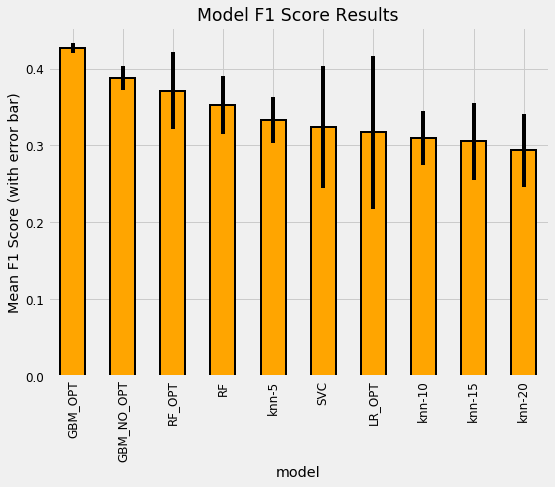

In [106]:
helper_functions.plot_model_results(model_results)

In [110]:
#Running GBM with SMOTETomek oversampling 

In [111]:
gbm_fi,valid_scores = model_gbm(features,labels,feat_cols,hyp=best_params,with_oversampling=True)

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.990585	valid's macro_f1: 0.378033
[400]	train's macro_f1: 0.9992	valid's macro_f1: 0.378209
Early stopping, best iteration is:
[44]	train's macro_f1: 0.880957	valid's macro_f1: 0.407369


'Fold 1, Validation Score: 0.40737, Estimators Trained: 44'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.992023	valid's macro_f1: 0.366028
[400]	train's macro_f1: 0.99888	valid's macro_f1: 0.375967
Early stopping, best iteration is:
[47]	train's macro_f1: 0.892893	valid's macro_f1: 0.410915


'Fold 2, Validation Score: 0.41092, Estimators Trained: 47'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.990911	valid's macro_f1: 0.389871
[400]	train's macro_f1: 0.9992	valid's macro_f1: 0.365268
Early stopping, best iteration is:
[14]	train's macro_f1: 0.782569	valid's macro_f1: 0.432674


'Fold 3, Validation Score: 0.43267, Estimators Trained: 14'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.991534	valid's macro_f1: 0.386693
[400]	train's macro_f1: 0.99888	valid's macro_f1: 0.392594
Early stopping, best iteration is:
[10]	train's macro_f1: 0.755859	valid's macro_f1: 0.403446


'Fold 4, Validation Score: 0.40345, Estimators Trained: 10'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.992327	valid's macro_f1: 0.352785
[400]	train's macro_f1: 0.998879	valid's macro_f1: 0.342396
Early stopping, best iteration is:
[10]	train's macro_f1: 0.771614	valid's macro_f1: 0.413435


'Fold 5, Validation Score: 0.41344, Estimators Trained: 10'

'5 cross validation score: 0.41357 with std: 0.01013.'

In [112]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_SMOTE"], 
                                                   'cv_mean': [np.mean(valid_scores)],
                                                   'cv_std':  [np.std(valid_scores)]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

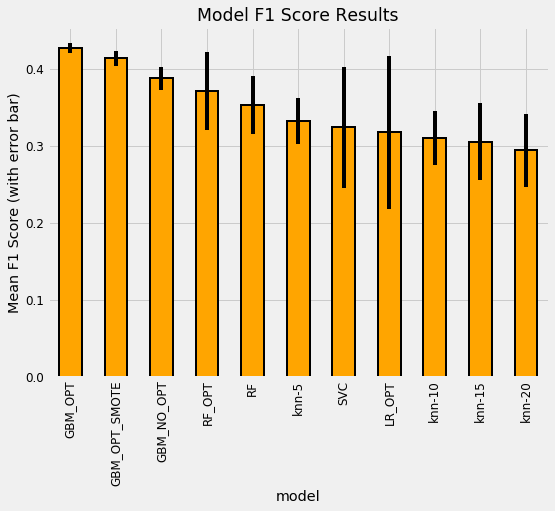

In [113]:
helper_functions.plot_model_results(model_results)

## GBM with Feature Selection

#### let us investigate the feature importances to check which features proved the most important for prediction.

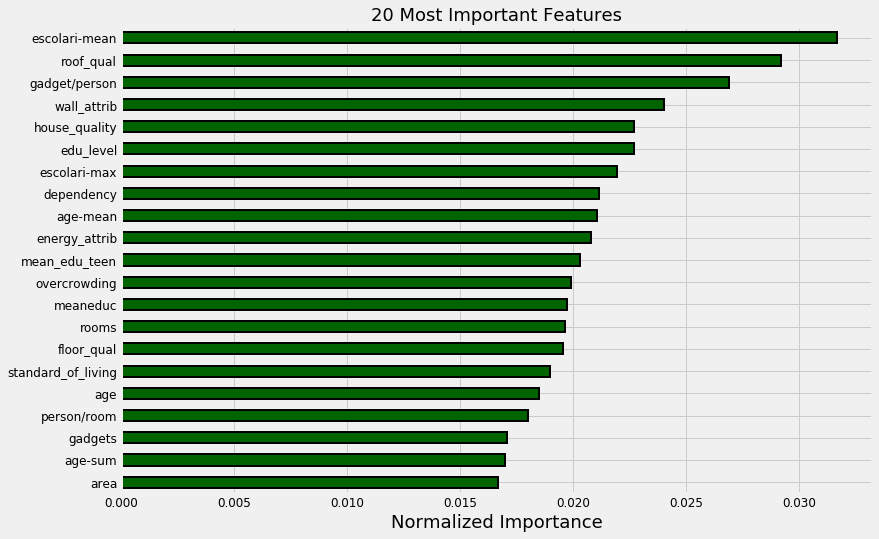

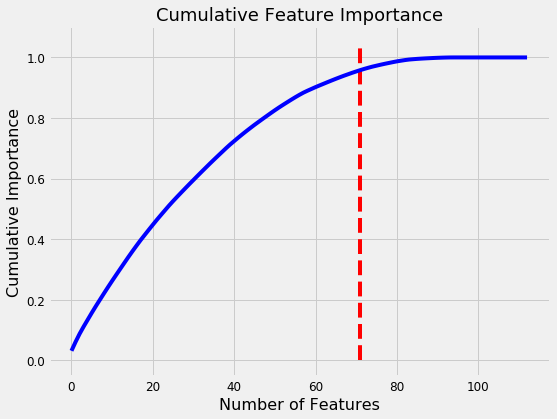

71 features required for 95% of cumulative importance.


In [114]:
feat_imp = plot_feature_importances(gbm_fi,threshold=0.95)

In [118]:
## let us select the first 69 features and check if we can get an improvement in score.

In [115]:
feat_sel = feat_imp.loc[0:71]['feature'].values

In [116]:
train_sel = train_head[feat_sel]

In [117]:
train_sel_scaled = scaler.fit_transform(train_sel)

In [118]:
gbm_fi,valid_scores = model_gbm(train_sel_scaled,labels,feat_sel,hyp=best_params,with_oversampling=True)

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.991219	valid's macro_f1: 0.371155
[400]	train's macro_f1: 0.99952	valid's macro_f1: 0.386551
Early stopping, best iteration is:
[34]	train's macro_f1: 0.865998	valid's macro_f1: 0.43176


'Fold 1, Validation Score: 0.43176, Estimators Trained: 34'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.991705	valid's macro_f1: 0.430666
[400]	train's macro_f1: 0.9992	valid's macro_f1: 0.411244
Early stopping, best iteration is:
[6]	train's macro_f1: 0.730004	valid's macro_f1: 0.44233


'Fold 2, Validation Score: 0.44233, Estimators Trained: 6'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.989318	valid's macro_f1: 0.425024
[400]	train's macro_f1: 0.998401	valid's macro_f1: 0.429334
Early stopping, best iteration is:
[139]	train's macro_f1: 0.977218	valid's macro_f1: 0.4446


'Fold 3, Validation Score: 0.4446, Estimators Trained: 139'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.991225	valid's macro_f1: 0.415829
[400]	train's macro_f1: 0.9992	valid's macro_f1: 0.406098
Early stopping, best iteration is:
[112]	train's macro_f1: 0.966501	valid's macro_f1: 0.450572


'Fold 4, Validation Score: 0.45057, Estimators Trained: 112'

Training until validation scores don't improve for 400 rounds.
[200]	train's macro_f1: 0.990115	valid's macro_f1: 0.35343
[400]	train's macro_f1: 0.998562	valid's macro_f1: 0.33379
Early stopping, best iteration is:
[28]	train's macro_f1: 0.839839	valid's macro_f1: 0.422573


'Fold 5, Validation Score: 0.42257, Estimators Trained: 28'

'5 cross validation score: 0.43837 with std: 0.00997.'

In [119]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_SEL_SMOTE"], 
                                                   'cv_mean': [np.mean(valid_scores)],
                                                   'cv_std':  [np.std(valid_scores)]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

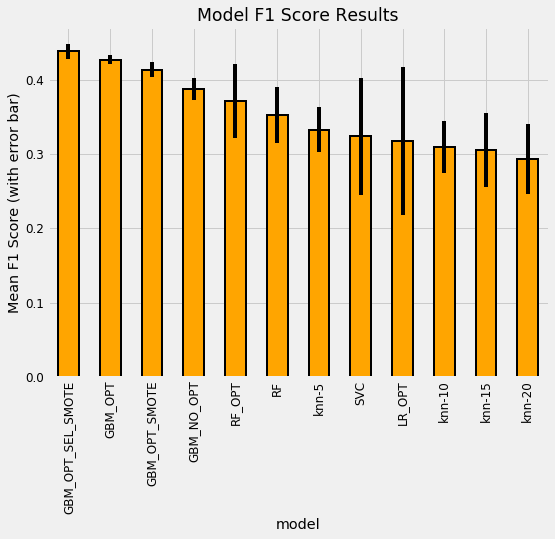

In [120]:
helper_functions.plot_model_results(model_results)